# Gaussian Process Regression

https://ml-course.github.io/master/notebooks/07%20-%20Bayesian%20Learning.html

'Gaussian Process Regression (GPR) is a *nonparametric*, *Bayesian* approach to regression'. https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319 
The Bayesian approach infers a *probability distribution* over all possible values. It works by specifying a **prior**, which is updated based on evidence according to **Bayes Theorem**:
$$ P(\theta|D) \propto P(D|\theta)P(\theta) $$
* $P(\theta|D)$ - posterior
* $P(\theta)$ - prior
* $P(D|\theta)$ - likelihood

The prior & likelihood is usually assumed to be Gaussian.

Like the Gaussian distribution, a Gaussian process is described by its **mean** $m(x)$ and its **covariance** $K(x,x')$ (given by the kernel above). Therefore, our function is:

$$ f(x) = \mathcal{GP} \left(m(x), K(x,x') \right)$$

Usually we take the mean to be 0.

The key assumption in GP modelling is that our data can be represented as a sample from a *multivariate Gaussian 
distribution*.

Inference in the Bayesian model is based on the **posterior**, computed by:

$$ p(\mathbf{w} | \mathbf{y}, X) = \frac{p(\mathbf{y}|X,\mathbf{w})p(\mathbf{w})}{p(\mathbf{y}|X)}$$

### Basic Introductory Example

https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [1]:
# Generating synthetic data
import numpy as np

X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

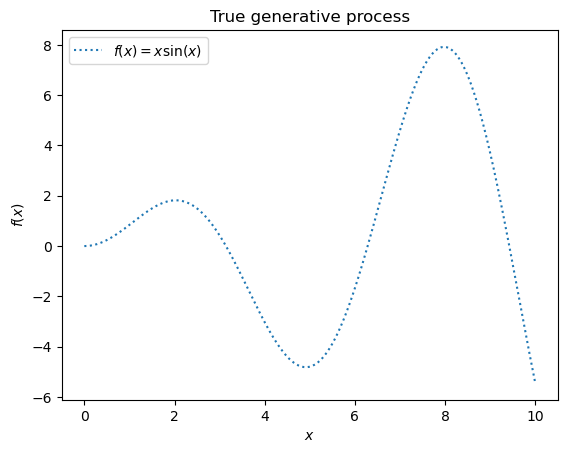

In [2]:
# Plotting data
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

This is the true value which our model is going to be tasked with calculating.

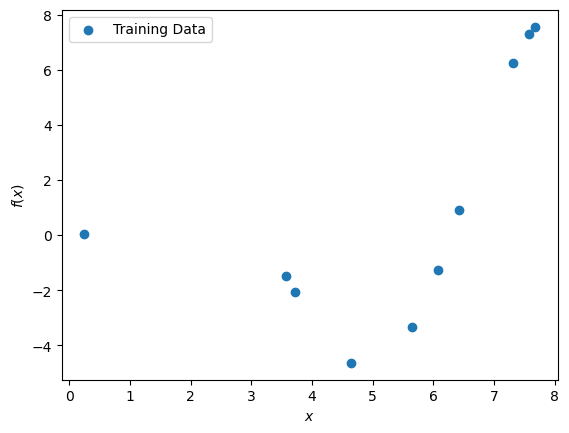

In [3]:
# Noise-free data
rng = np.random.RandomState(11) # keeping seed constant
training_indices = rng.choice(np.arange(y.size), size=10, replace=False) # 10 random indicies from df
X_train, y_train = X[training_indices], y[training_indices] # x & y values of random indicies

plt.scatter(X_train, y_train, label='Training Data')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$");

This is the data we are giving to our Gaussian Processor. For the time being we are not adding any noise.

The **Covariance Function** or **kernel** for a Gaussian is often given by: $k(x,x') = \sigma_f^2 \exp{\left(-\frac{\lvert\lvert{x-x'} \rvert\rvert^2}{2 l^2}\right)}$. 

$$ K = \begin{bmatrix}
         k(x_1, x_1) & k(x_1, x_2) & \dots & k(x_1, x_n)\\
         k(x_2, x_1) & k(x_2, x_2) & \dots & k(x_2, x_n)\\
         \vdots & \vdots & \ddots & \vdots\\
         k(x_n, x_1) & k(x_n, x_2) & \dots & k(x_n, x_n)\\
         \end{bmatrix}
         $$

Each observation $y$ can be thought of as related to an underlying function $f(x)$ through a Gaussian noise model: $y = f(x) + \mathcal{N}(0,\sigma_n^2)$. This is very similar to what we did with regression.

To prepare for GPR, we calculate the covariance function. Since the key assumption in GP modelling is that our data can be represented as a sample from a multivariate Gaussian distribution, for a data set $\mathbf{y}$ we have:

$$\begin{bmatrix}
 \mathbf{y}\\
 y*
\end{bmatrix} \sim N\left(0, \begin{bmatrix}
                             K & K_* \\
                             K_*^T & K_{**}
                             \end{bmatrix} \right)$$

where $K_* = \begin{bmatrix}
              k(x_*, x_1) & k(x_*, x_2) & \dots & k(x_*, x_n)
              \end{bmatrix}$
and $K_{**} = k(x_*, x_*) $

Our **posterior** is $p(y_* | \mathbf{y})$. The mean value of $y_*$:
$$ \overline{y}_* = K_* K^{-1} \mathbf{y} $$ 

and the variance is:

$$Var(y_*) = K_{**} - K_*K^{-1}K_*^T$$

The parameters, $\mathbf{\theta} = \{l, \sigma_f, \sigma_n\}$, are what we are trying to optimise for our model to be as accurate as possible. 

In order to optimise this, similar to linear regression, we need to *maximise* the log of the *posterior*. 

$$ \log{p(\mathbf{y}|\mathbf{x},\mathbf{\theta})} = -\frac{1}{2} \mathbf{y}^T K^{-1} \mathbf{y} - \frac{1}{2}\log{|K|} - \frac{n}{2} \log{2 \pi} $$

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


12.8**2 * RBF(length_scale=2.56)

See statistics notes for more information about kernels.

For information about the scipy module see https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

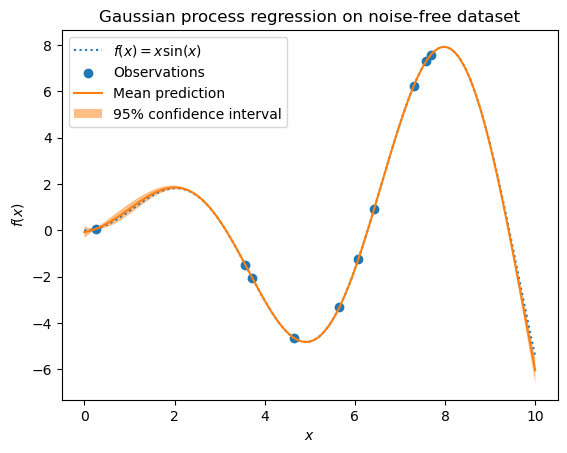

In [5]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)


plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted") # true value
plt.scatter(X_train, y_train, label="Observations") # training data
plt.plot(X, mean_prediction, label="Mean prediction") # gp prediction
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction, # 95% confidence interval
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)                                                
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset");

#### Comment on plot:
The above plot shows how the Gaussian Process regression works. We start off with some randomly selected data from our function, and simply tell our code that the data follows a Gaussian distribution with a Gaussian kernel. The GP then predicts the values of $f(x)$ based on the very limited information given, as well as the uncertainty in the values. We then plot the prediction with a shaded region representing 95% confidence in the values. We see that the confidence levels changes through the graph, with the largest confidence interval occuring at the end in this case.

https://www.apps.stat.vt.edu/leman/VTCourses/GPtutorial.pdf

## Gaussian Process Regression with PyMC3

https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Marginal.html

The process undertaken below is another example of a Gaussian process, although this one is using **PyMC3** instead of **Sklearn** to implement it.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp

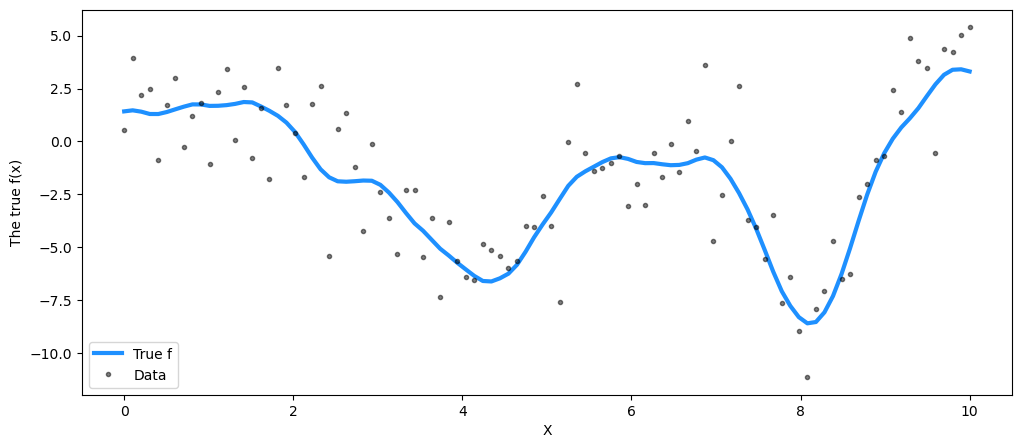

In [7]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

#### Comment on plot:

This dataset we are working with is far more complicated than the one we used with scikit-learn, and the data points are very randomly scattered. However, this is more indicative of our actualy sunspot data, which is both very random and very scattered.

### Defining the *kernel*

In [8]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ) # predefined covariance function
    gp = pm.gp.Marginal(cov_func=cov) # implementation of the sum of a GP prior and noise

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    mp = pm.find_MAP() # finds local maximimum 'a posteriori point' given a model

In [9]:
mp

{'ℓ_log__': array(0.00460842),
 'η_log__': array(1.24959788),
 'σ_log__': array(0.64421439),
 'ℓ': array(1.00461906),
 'η': array(3.4889397),
 'σ': array(1.90449025)}

In [10]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame(
    {
        "Parameter": ["ℓ", "η", "σ"],
        "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
        "True value": [ℓ_true, η_true, σ_true],
    }
)

,Parameter,Value at MAP,True value
0,ℓ,1.004619,1.0
1,η,3.488940,3.0
2,σ,1.904490,2.0


### Using .conditional

In [11]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'], samples=2000)

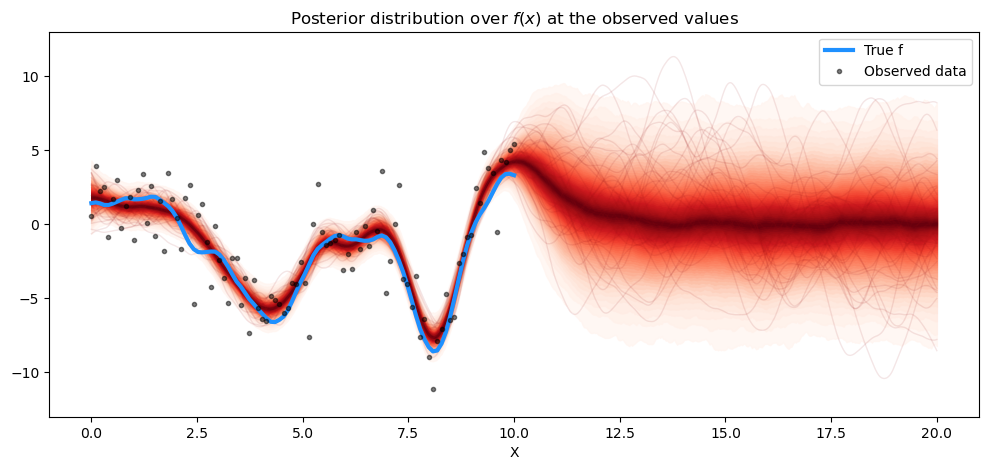

In [12]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples['f_pred'], X_new)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

#### Comment on plot:

We see by the red contour on this plot that the the Gaussian process makes a very good prediction of the function, with the general shape of the contour following the *True f* line. 

However some of the definition of the *True* line isn't captured very clearly. This might be improved with a shorted value for $l$ in the *kernel*.

The general takeaway from this plot is that the Gaussian process can very accurately predict the function of the line, which would be useful in our Sunspot data for predicting the SVG smoothed signals, but is there a way to predict the actualy ***data points***, which are quite noisy and scattered from the *true* line?

We can use ***pred_noise*** in *gp.Marginal* to predict the noisy data points.

In [13]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], var_names=['y_pred'], samples=2000)

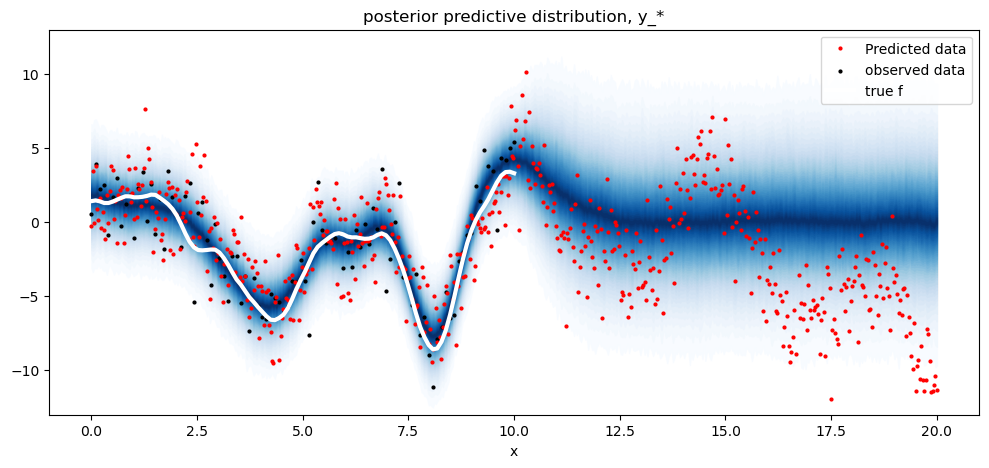

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="Blues")

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "ro", ms=2, label="Predicted data")

# plot original data and true function
plt.scatter(X, y, color='black', s=4, alpha=1.0, label="observed data")
plt.plot(X, f_true, "white", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("posterior predictive distribution, y_*")
plt.legend();

#### Comment on plot:

The red points above are our predicted data points, and when we compare them to the available *true datapoints* in black, we see that they seem to fit in with the real points.

As before, we can calculate the mean values and plot the mean, the uncertainty, and the true value.

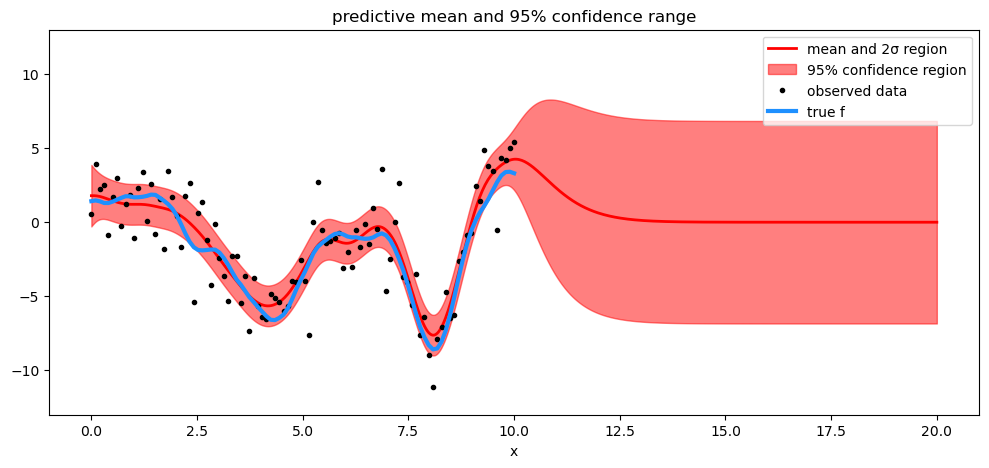

In [15]:
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2σ region")
plt.fill_between(X_new.flatten(), mu - 1.96 * sd, mu + 1.96 * sd, color="r", alpha=0.5, label='95% confidence region')

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("predictive mean and 95% confidence range")
plt.legend();

#### Comment on plot:

This plot shows the predictive mean, along with the 95% confidence zone which has been shaded on the graph.

## Gaussian Process Regression with TensorFlow

https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP

In [16]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D
%pylab inline
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

2023-02-21 10:19:23.100885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cov', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [17]:
def sinusoid(x):
      return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
    """Generate noisy sinusoidal observations at a random set of points.

      Returns:
         observation_index_points, observations
      """
    index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
    index_points_ = index_points_.astype(np.float64)
      # y = f(x) + noise
    observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
    return index_points_, observations_

In [18]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

In [19]:
def build_gp(amplitude, length_scale, observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

  # Create the covariance kernel, which will be shared between the prior (which we
  # use for maximum likelihood training) and the posterior (which we use for
  # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  # Create the GP prior distribution, which we will use to train the model
  # parameters.
    return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

2023-02-21 10:19:33.114237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=0.22259219423781773>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.968057611883692>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=1.7271295839176832>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-2.94421006e+00, -2.67500061e+00, -2.69852086e+00, -2.00639668e+00,
       -2.70776537e-01, -1.04541297e+00, -1.76971117e+00, -3.21357013e+00,
       -9.16878999e-01, -1.18825191e+00, -3.03246644e-01, -2.14961246e+00,
       -9.71638184e-01, -2.69091983e-01, -1.80592015e-01, -7.92010309e-01,
        5.88574835e-01, -2.37014001e+00, -1.85534921e+00, -1.59585809e-01,
       -2.76354644e+00, -2.21235468e+00, -2.92422928e+00, -1.78039434e+00,
       -4.40919444e+00, -1.53132529e-01, -4.30324777e-01, -2.02452193e+00,
       -2.15627665e-01, -9.68515545e-02, -1.57752770e+00, -3.5042

In [21]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]

In [22]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

In [23]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
      loss = -target_log_prob(amplitude_var, length_scale_var,
                              observation_noise_variance_var)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.8600546589711542
length_scale: 0.17942106930290241
observation_noise_variance: 0.09556735680552958


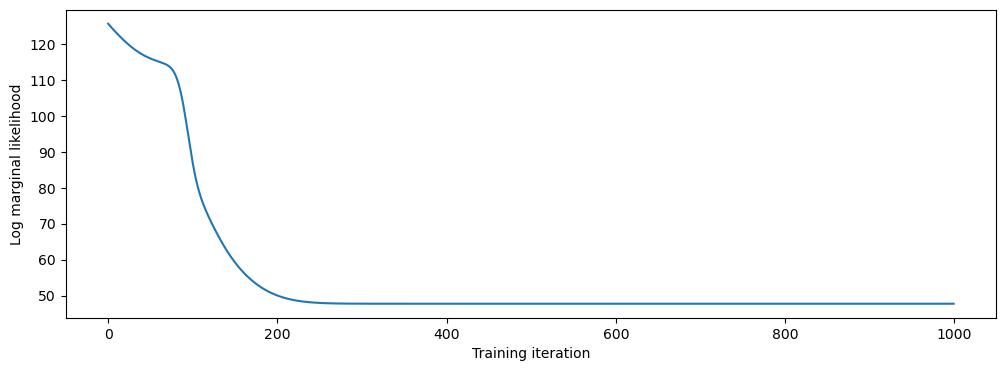

In [24]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [25]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

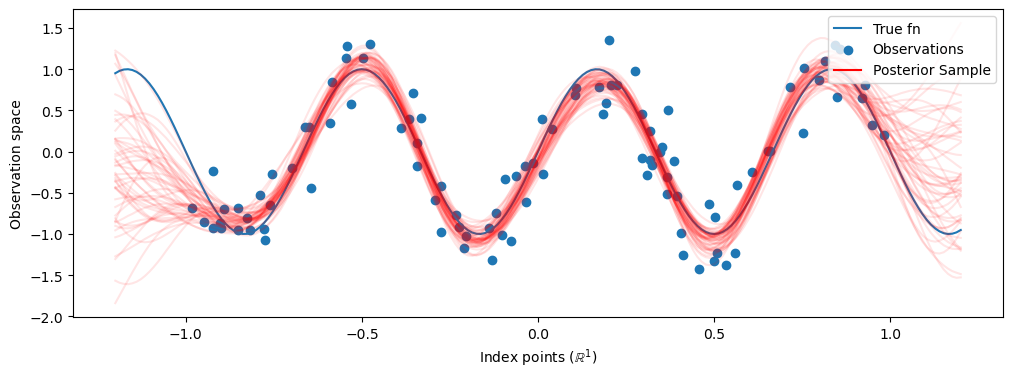

In [26]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

In [27]:
num_results = 100
num_burnin_steps = 50

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64)),
    bijector=[constrain_positive, constrain_positive, constrain_positive])

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

In [28]:
# Speed up sampling by tracing with `tf.function`.
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
    return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=lambda current_state, kernel_results: kernel_results)

t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))

Inference ran in 13.19s.


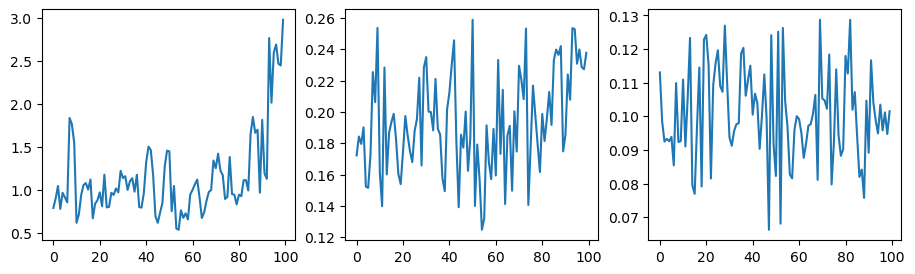

In [29]:
(amplitude_samples,
 length_scale_samples,
 observation_noise_variance_samples) = samples

f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
    ax = f.add_subplot(1, len(samples) + 1, i + 1)
    ax.plot(s)

In [30]:
# The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
# so they construct a *batch* of kernels.
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples, length_scale_samples)

# The batch of kernels creates a batch of GP predictive models, one for each
# posterior sample.
batch_gprm = tfd.GaussianProcessRegressionModel(
    kernel=batch_of_posterior_kernels,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_samples,
    predictive_noise_variance=0.)

# To construct the marginal predictive distribution, we average with uniform
# weight over the posterior samples.
predictive_gprm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
    components_distribution=batch_gprm)

num_samples = 50
samples = predictive_gprm.sample(num_samples)

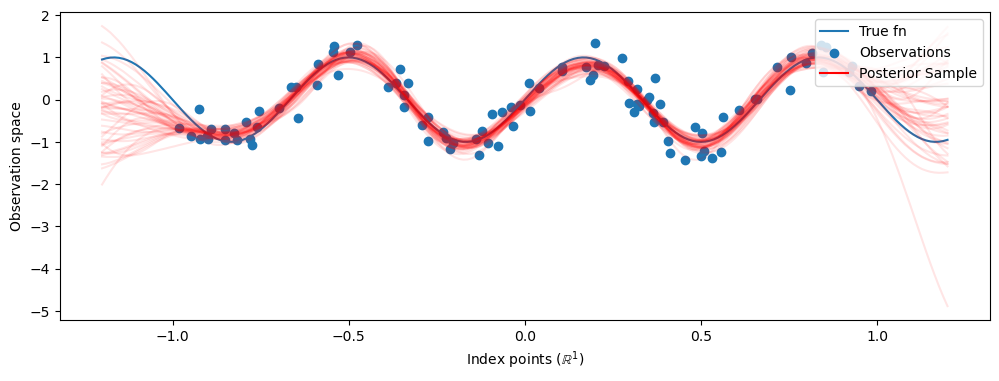

In [31]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

***
## Gaussian Process from Scratch

In order to better understand GP's I will attempt to create one from scratch. 

The first step in creating a GP is to define a kernel. For this I will be using thr **squared exponential (SE)** kernel.

In [32]:
def kernel(x, y, p):
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)

For simplicity, we will set the mean function $m = 0$, which is the default for prebuilt GPs.

To show how a GP 'evolves' as the number of data points increases we start by fitting to just a single point:

In [33]:
t_1= [1.0]
y_1 = [0.1]

Looking back at the previous notes on GP, we arrived at the conclusion that we need to maximise the log likelihood function, given by

$$ \log{p(\mathbf{y_1})} = -\frac{1}{2} \mathbf{y_1}^T K^{-1} \mathbf{y_1} - \frac{1}{2}\log{|K|} - \frac{n}{2} \log{2 \pi} $$

In [34]:
def like(y1, A):
    return (2.0 * np.pi * np.linalg.det(A))**-0.5 * np.exp(-0.5 * np.dot(y1, np.linalg.inv(A).dot(y1)))

Recalling the important **Bayes theorem**, the posterior of our GP is given by:$$ p(\mathbf{y_2} | \mathbf{y_1}) = \frac{p(\mathbf{y_1},\mathbf{y_2})p(\mathbf{y_2})}{p(\mathbf{y_1})}$$

where $$ p(\mathbf{y_1}, \mathbf{y_2}) = \mathcal{N} \left(\begin{bmatrix} 
                                     \mathbf{a} \\
                                     \mathbf{c}
                                     \end{bmatrix},  \begin{bmatrix} 
                                                      A & B \\
                                                      B^T & C
                                                      \end{bmatrix} \right)$$
                                                      
The above equation is used to give us a prediction and uncertainty.
                                                      
See *Notes on Statistics* for more, but the important end result is that the posterior is given by:
                                                      
$$ p(\mathbf{y_2} | \mathbf{y_1}) = \mathcal{N} \left(\mathbf{c} + BA^{-1}(\mathbf{y_1} - \mathbf{a}), C - BA^{-1}B^T \right), $$ 

if the mean is zero then $c = a = 0$. This is then used to give us a prediction $BA^{-1}(y_1)$ and covariance function $C - BA^{-1}B^T$.

We need to write a function which accepts arguments $t_2; t_1$, the kernel parameters $\theta$, and the observed data points $y_1$.


In [36]:
def predict(t_2, t_1, kernel, p, y_1):
    B = kernel(t_1, t_2, p).T
    C = kernel(t_2, t_2, p)
    A = kernel(t_1, t_1, p)
    Ainv = np.linalg.inv(A)
    y_pred = np.dot(B, Ainv).dot(y_1)
    sigma_new = C - np.dot(B, Ainv).dot(B.T)
    return y_pred, sigma_new.diagonal()

In [37]:
# Data point and kernel parameters
t_1= [1.0]
y_1 = [0.1]
t_2 = np.linspace(0, 2, 200)
theta = [1.0, 0.1]
y_pred, sigmas = predict(t_2, t_1, kernel, theta, y_1)

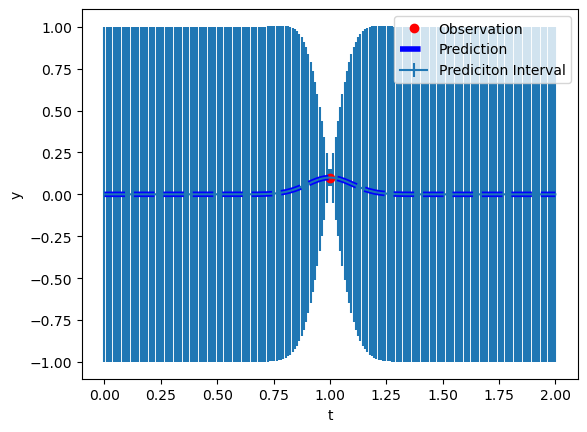

In [38]:
fig, ax = plt.subplots()
ax.errorbar(t_2, y_pred, yerr=sigmas**0.5, capsize=0, label='Prediciton Interval')
ax.plot(t_1, y_1, 'ro', label='Observation')
ax.plot(t_2, y_pred, 'b--', lw=4, label='Prediction')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('y');

We see here that our predictions form a Gaussian distribution with a mean at our single data point. This is how a GP works, by modelling each data point as having a **multivariate gaussian distribution**.

The uncertainties are small at points close to the data-point, but rapidly increase as we move further away from our known value. GPs are useful as we obtain a measure of the uncertainty of any predictions.

If we add another data point we can see how our GP changes.

In [39]:
t_1.append(1.2)
y_1.append(0.6)
y_pred, sigmas = predict(t_2, t_1, kernel, theta, y_1)

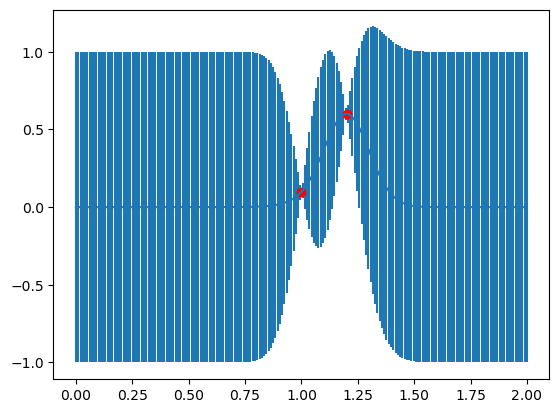

In [40]:
plt.errorbar(t_2, y_pred, yerr=sigmas**0.5, capsize=0)
plt.plot(t_1, y_1, 'ro');

With each additional data point we add, our GP has a different mean and covariance output, and we obtain a prediction which is sensible.

In [41]:
t_1 = [0.4, 0.7, 1.1, 2.3, 2.9, 3.0]
theta = [1.0, 0.3]
y_1 = np.random.multivariate_normal(np.zeros(len(t_1)), kernel(t_1, t_1, theta))
t_2 = np.linspace(0, 4, 1000)
y_pred, sigmas = predict(t_2, t_1, kernel, theta, y_1)

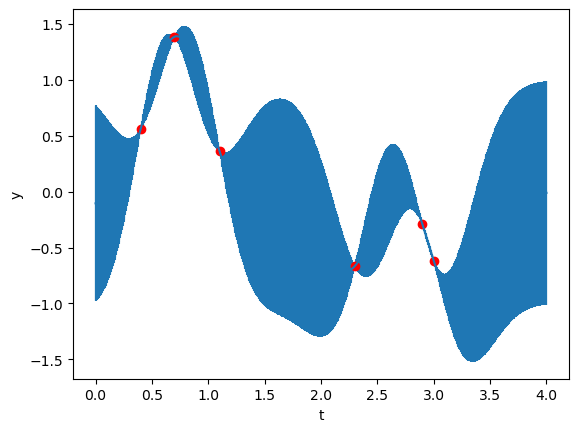

In [42]:
plt.errorbar(t_2, y_pred, yerr=sigmas**0.5, capsize=0)
plt.plot(t_1, y_1, 'ro')
plt.xlabel('t')
plt.ylabel('y');